<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>TeradataML Package for the logistics of Data Science and Advanced Analytics</b>
<br>
<b style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Load, Analyze, and Transform Data At Scale</b>
</header>


<p style = 'font-size:16px;font-family:Arial'><b>Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Python Package User Guide: <a href = 'https://docs.teradata.com/r/1YKutX2ODdO9ppo_fnguTA/root'>https://docs.teradata.com/r/1YKutX2ODdO9ppo_fnguTA/root</a></li>
    <li>Teradataml Python Reference: <a href = 'https://docs.teradata.com/r/xLnbN80h9C6037gi3ildag/root'>https://docs.teradata.com/r/xLnbN80h9C6037gi3ildag/root</a></li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>Contents</b></p>
<ol style = 'font-size:16px;font-family:Arial'>
    <li>Connect to the Vantage environment</li>
    <li>Create and Load Tables from source data sets</li>
    <li>Basic Data Discovery.  Metadata and feature analysis</li>
    <li>Working with Data - aggregations, joins, and basic transformations</li>
    <li>Advanced Data Preparation - column assignments using complex functions</li>
    <li>Visualizing results.</li>
</ol>

<hr>

<b style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Architecture of the Teradataml package</b>
<p style = 'font-size:16px;font-family:Arial'>Teradataml seeks to provide easy-to-use interfaces for working with data that resides in a Teradata Vantage system.  Typically, Python developers will make use of common, powerful data management functions using libraries like python pandas.  Teradataml extends these same functions to the Teradata ecosystem, allowing users to apply straightforward, powerful analytics and data manipulation functions that leverage the full power and scale of Vantage without data movement or limitations on client resources without writing complex SQL.</p>

<p style = 'font-size:16px;font-family:Arial'>Teradataml package utilizes SQLAlchemy and Pandas capabilities to provide this translation between the two environments as illustrated below:</p>
<img src = "Functional_Diagram.png">

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Experience</b></p>
<p style = 'font-size:16px;font-family:Arial'>The Experience section takes about 5 minutes to run.</p>

In [1]:
# import statements
import json
import getpass
import os
import warnings

import pandas as pd
import numpy as np

from teradataml.dataframe.dataframe import DataFrame
from teradataml.dataframe.dataframe import in_schema
from teradataml.context.context import create_context, remove_context
from teradataml.dataframe.copy_to import copy_to_sql
from teradataml.dataframe.fastload import fastload

import tdconnect

from sqlalchemy import create_engine
from sqlalchemy import func

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Suppress Warnings
warnings.filterwarnings('ignore')

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Section 1. Connecting to Vantage</b>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Make changes for your execution</b></p>

<p style = 'font-size:16px;font-family:Arial'>The Jupyter Module for Teradata provides a helper library called tdconnect - this can use the underlying client configs and pass a JWT token for SSO. Establish connection to Teradata Vantage server (uses the Teradata SQL Driver for Python). Before you execute the following statement, replace the variables &ltHOSTNAME&gt, &ltUID&gt and &ltPWD&gt with your target Vantage system hostname (or IP address), and your database user ID(QLID) and password, respectively.</p>
    
<p style = 'font-size:14px;font-family:Arial'>td_context = create_context(host="tdprdX.td.teradata.com", username="xy123456", password=gp.getpass(prompt='Password:'), logmech="LDAP")</p>

In [2]:
eng = tdconnect.create_context('Vantage-LIVE')

print(type(eng))

<class 'sqlalchemy.engine.base.Engine'>


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Section 2. - Create and Load Tables</b>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Load Sample Data from CSV Files if needed</b></p>

<p style = 'font-size:16px;font-family:Arial'>If these tables already exist in the database, you don't need to run this section</p>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>2.1  Create Demo Transaction data - simulated funds transfers.  Use FastLoad to create and import data</b></p>

In [3]:
#Read the CSV data into a local pandas dataframe
ip_data = pd.read_csv('Transactions_60K.csv')

#Little bit of code that creates an index
ip_data['txn_id'] = range(1, len(ip_data) + 1)

#Load the Data:
#Fastload protocol is nice for row counts over 100K - shown here as an illustration
#These Teradata functions have lots of parameters to help control behavior - 
#The if_exists parameter is nice so we don't have to explictly drop the table before loading it - or we can append, etc.

fastload(ip_data, 
         table_name='ip_data', 
         primary_index='txn_id', 
         if_exists = 'replace')

#Can also use copy_to_sql for smaller row counts and more flexibility

Processed 63626 rows in batch 1.


{'errors_dataframe': Empty DataFrame
 Columns: []
 Index: [],
 'warnings_dataframe': Empty DataFrame
 Columns: []
 Index: [],
 'errors_table': '',
 'warnings_table': ''}

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>2.2  Create Simulated Customer Data - load from CSV using SQL to create the table</b></p>
<p style = 'font-size:16px;font-family:Arial'>In the example above, we created our table automatically by calling the Fastload.  These functions allow us to define data types, encoding, and other parameters.  However if we want more control, we can use SQL to create the table.  In the below example, we need the "ST_GEOMETRY" data type which isn't currently supported in the built-in functions.</p>

In [4]:
#Customer Table - drop if it exists
#Note the use of try/except - this is a handy way of checking if the table exists, and quitely failing

qry = 'DROP TABLE CUSTOMER;'

try:
    eng.execute(qry)
except Exception as e:
        if str(e.args).find("3807") >= 1:
            pass
        else:
            raise
            
#Create Demo customer data table.  Python is handy here because we can do string substitutions and other neat things


qry = '''
CREATE MULTISET TABLE CUSTOMER, NO FALLBACK,
     NO BEFORE JOURNAL,
     NO AFTER JOURNAL,
     CHECKSUM = DEFAULT,
     DEFAULT MERGEBLOCKRATIO
(
    CUSTOMER_ID DECIMAL(18,0) NOT NULL,
    F_NAME VARCHAR(30),
    L_NAME VARCHAR(30),
    VALIDITY VARCHAR(60),
    CUST_ZIP VARCHAR(5),
    CUST_LOCATION ST_GEOMETRY,
    ETHNICITY VARCHAR(20),
    GENDER CHAR(1),
    CHURN_FLAG VARCHAR(1)
)
INDEX(CUST_LOCATION);
'''

# Execute Query
eng.execute(qry)

In [5]:
#load the customer data - we're using the table created above, and reading the tdf directly - note we have flexibility on
#different delimiters - this case is a tab
copy_to_sql(pd.read_csv('CUSTOMER.tdf', sep='\t'), table_name='CUSTOMER')

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>2.3  Create Simulated Customer Comment Table.  Use copy_to_sql to create the table and load the data</b></p>

In [6]:
#load the data
copy_to_sql(pd.read_csv('CUST_COMMENT.csv'), 
            table_name='CUST_COMMENT', 
            if_exists = 'replace')

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>2.4  Additional Simulated Data - Server Locations.  Use SQL to handle the ST_GEOMETRY data type </b></p>
<p style = 'font-size:16px;font-family:Arial'>This shows an example where the automatic typing won't work, so we can use native SQL to overcome the limitations</p>

In [7]:
#Demo e-commerce server table - drop if it exists

qry = 'DROP TABLE SERVER;'
# Execute Query

try:
    eng.execute(qry)
except Exception as e:
        if str(e.args).find("3807") >= 1:
            pass
        else:
            raise

#Create Demo e-commerce server table - we need the ST_GEOMETRY type again - use SQL


qry = '''
CREATE MULTISET TABLE SERVER, NO FALLBACK,
     NO BEFORE JOURNAL,
     NO AFTER JOURNAL,
     CHECKSUM = DEFAULT,
     DEFAULT MERGEBLOCKRATIO
(
    SERVER_ID VARCHAR(5) NOT NULL,
    SERVER_ZIP VARCHAR(5),
    SERVER_LOCATION ST_GEOMETRY
)
INDEX (SERVER_LOCATION);
'''

# Execute Query
eng.execute(qry)

In [8]:
#load the data - read the csv file using pandas read_csv
srvr = pd.read_csv('SERVER.csv')
srvr.rename(columns = {'SERVER ZIP':'SERVER_ZIP','SERVER_LAT':'SERVER_LOCATION'}, inplace = True)

copy_to_sql(srvr, table_name='SERVER')

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Section 3 - Data Discovery</b>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Look at table statistics, sample data, simple lookups</b></p>

<p style = 'font-size:16px;font-family:Arial'>One of the most powerful features of the teradtaml functions is that they push processing down to the Teradata system, allowing users to perform analysis without pulling all the data back to the client.</p>

In [9]:
#Get a teradata DataFrame - this creates a local reference to the large table on the server.
tdf_ip_data = DataFrame('ip_data')

#Check the data - size and sample rows without returning all the data
print(tdf_ip_data.shape)

#I can return a small set of the data back to a traditional Pandas DF for full-featured formatting.
tdf_ip_data.to_pandas(num_rows = 5).head()

(63626, 12)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
txn_id,,,,,,,,,,,
57250,163,CASH_IN,116111.79,C1881145462,26948355.12,27064466.91,C168698757,251988.69,135876.90,0,0
5382,43,CASH_OUT,250426.58,C237150183,0.00,0.00,C234235840,324119.46,574546.03,0,0
60160,207,CASH_OUT,40803.09,C514128000,45420.00,4616.91,C813097043,191439.05,232242.14,0,0
5221,324,TRANSFER,887861.93,C643464864,92497.00,0.00,C1373750687,3307997.56,4195859.49,0,0
33039,95,PAYMENT,2966.70,C1898120439,10950.00,7983.30,M1108014483,0.00,0.00,0,0


In [10]:
# check for null values.
tdf_ip_data.info(null_counts = True)

<class 'teradataml.dataframe.dataframe.DataFrame'>
Data columns (total 12 columns):
step              63626 non-null int  
type              63626 non-null str  
amount            63626 non-null float
nameOrig          63626 non-null str  
oldbalanceOrg     63626 non-null float
newbalanceOrig    63626 non-null float
nameDest          63626 non-null str  
oldbalanceDest    63626 non-null float
newbalanceDest    63626 non-null float
isFraud           63626 non-null int  
isFlaggedFraud    63626 non-null int  
txn_id            63626 non-null int  
dtypes: int(4), float(5), str(3)


In [11]:
#Generate Stats using Teradata DataFrame describe method - similar to pandas but it runs on the server, we don't need to retrieve all the data.
tdf_ip_data.describe()

func,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,txn_id
std,142.318,625628.888,2866643.897,2901040.554,3552471.713,3910769.595,.038,0,18367.388
25%,156,13561.99,0,0,0,0,0,0,15907.25
50%,239,76313.375,14441.84,0,131176.075,216585.735,0,0,31813.5
75%,335,210643.125,107501.635,145702.508,954010.54,1133398.633,0,0,47719.75
max,718,36946551.76,44892193.09,34892193.09,219244799.8,233909900.9,1,0,63626
min,1,.79,0,0,0,0,0,0,1
mean,243.939,184019.525,832860.089,854203.893,1122750.26,1256132.554,.001,0,31813.5
count,63626,63626,63626,63626,63626,63626,63626,63626,63626


In [12]:
#apply a set of expressions on the virtual dataframe using loc (pandas set processing technique) to grab all fraudulent values
#The logic here will filter fraudulent transactions of type 'TRANSFER' - as a view on the server, not actually move the data at all.
#calling head(2) will only retrieve two values from the sever

#This table could be billions of rows, and only returns the two values we request.

tdf_ip_data.loc[(tdf_ip_data.isFraud == 1) & (tdf_ip_data.type == 'TRANSFER')].head(2)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,txn_id
276,TRANSFER,1567591.24,C1295443216,1567591.24,0.0,C1682101725,0.0,0.0,1,0,865
624,TRANSFER,24366.07,C113775713,24366.07,0.0,C405489983,0.0,0.0,1,0,665


In [13]:
#filter the dataframe, then only retrive two rows of results
tdf_ip_data.loc[tdf_ip_data.isFraud == 1].filter(items = ['amount', 'isFraud', 'type']).head(2)

amount,isFraud,type
18982.32,1,TRANSFER
9748.89,1,CASH_OUT


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Section 4 - Working with Data at Scale</b>

<p style = 'font-size:16px;font-family:Arial'>Act on our data sets without having to return all of the data, and leverage the computing power of the Teradata Vantage cluster.</p>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.1 Aggregations</b></p>

<p style = 'font-size:16px;font-family:Arial'>We can use these "fluent" methods to keep the code as brief and expressive as possible</p>

In [14]:
#count each instance of fraud grouped by transaction type
#note the only data that actually moves out of the database is the final count() aggregation.

tdf_ip_data.loc[tdf_ip_data.isFraud == 1].filter(items = ['amount', 'isFraud', 'type']).groupby('type').count()

type,count_amount,count_isFraud
CASH_OUT,45,45
TRANSFER,47,47


In [15]:
#max and min fraud amounts by type - use agg() to use multiple aggregates
tdf_ip_data.loc[tdf_ip_data.isFraud == 1].filter(items = ['amount', 'isFraud', 'type']).groupby('type')\
  .agg({'amount' : ['min', 'max']})

type,min_amount,max_amount
CASH_OUT,9748.89,7060216.94
TRANSFER,18982.32,10000000.0


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.2 Simple Transformations</b></p>

<p style = 'font-size:16px;font-family:Arial'>Create new "Virtual Dataframes" that are the result of dropping columns or adding new ones via simple expressions</p>

In [16]:
#Create a new df with flagged fraud, and Drop columns
clean_data = tdf_ip_data.loc[tdf_ip_data.isFraud == 1].drop(['nameDest', 'nameOrig', 'isFlaggedFraud'], axis = 1)
clean_data.head(2)

step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,txn_id
624,TRANSFER,24366.07,24366.07,0.0,0.0,0.0,1,665
50,CASH_OUT,592737.43,592737.43,0.0,163646.39,756383.82,1,260


In [17]:
#Assign a new column with the difference between newbalanceDest and amount of transaction 
#Note assign needs to be used, as traditional implicit columns assignments aren't translated
#Meaning df['new_col'] = df['old1'] - df['old2']
clean_data = clean_data.assign(diff = clean_data['newbalanceDest'] - clean_data['amount'])
clean_data.head(2)

step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,txn_id,diff
624,TRANSFER,24366.07,24366.07,0.0,0.0,0.0,1,665,-24366.07
50,CASH_OUT,592737.43,592737.43,0.0,163646.39,756383.82,1,260,163646.3899999999


In [18]:
#String assigment/operators
#Create a new column which is the binary representation of transaction type
clean_data = clean_data.assign(btype = clean_data['type'].str.contains('CASH_OUT'))
clean_data.head(5)

step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,txn_id,diff,btype
276,TRANSFER,1567591.24,1567591.24,0.0,0.0,0.0,1,865,-1567591.24,0
431,CASH_OUT,526071.46,526071.46,0.0,987448.67,1513520.12,1,2114,987448.6600000001,1
525,CASH_OUT,203280.85,203280.85,0.0,0.0,203280.85,1,2062,0.0,1
624,TRANSFER,24366.07,24366.07,0.0,0.0,0.0,1,665,-24366.07,0
50,CASH_OUT,592737.43,592737.43,0.0,163646.39,756383.82,1,260,163646.3899999999,1


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.3 Joins</b></p>
<p style = 'font-size:16px;font-family:Arial'>Join dataframes using python pandas-style join methods</p>

In [19]:
#Set up for Join - create two dataframes (dimension (customer) - and fact (comment) table)
tdf_customer = DataFrame('CUSTOMER')
tdf_customer.head(5)

CUSTOMER_ID,F_NAME,L_NAME,VALIDITY,CUST_ZIP,CUST_LOCATION,ETHNICITY,GENDER,CHURN_FLAG
1484.000,Theresa,Norris,"(2010-06-13, 9999-12-31)",,POINT (-75.426144 41.827285),Pacific Islander,F,N
1526.000,Norris,Tucker,"(2010-04-04, 9999-12-31)",,POINT (-78.78418 38.31321),African American,M,N
1484.000,Theresa,Norris,"(2009-11-02, 2010-06-12)",,POINT (-90.637706 36.587245),Pacific Islander,F,N
1455.000,Helena,Mcgee,"(2011-08-26, 9999-12-31)",,POINT (-74.940368 39.221854),Hispanic,F,N
1455.000,Helena,Mcgee,"(2011-01-15, 2011-08-25)",,POINT (-83.115979 37.369184),Hispanic,F,N


In [20]:
tdf_cust_comment = DataFrame('CUST_COMMENT')
tdf_cust_comment.head(5)

COMMENT_ID,CUSTOMER_ID,COMMENT_DT,CHANNEL_TYPE,CHANNEL_ID,COMMENT_TEXT
T000010002,67167,2018-04-13 01:50:00.000,C,C0000503837,Sample comment
T000010004,99187,2018-04-13 01:50:00.000,C,C0000505422,Sample comment
T000010003,131207,2018-04-13 01:50:00.000,C,C0000506861,Sample comment
T000010001,99187,2018-04-13 01:43:00.000,W,W0000206454,Sample comment
T000010000,67167,2018-04-13 01:43:00.000,W,W0000206453,Sample comment


In [21]:
#Do an inner join and clean up fields I don't need.
tdf_comment_full = tdf_cust_comment.join(other = tdf_customer, 
                                         on = ['CUSTOMER_ID = CUSTOMER_ID'], 
                                         how = 'inner', 
                                         lsuffix = 'cID_', 
                                         rsuffix = 'cOM_')
tdf_comment_full.drop(['COMMENT_ID', 'cOM__CUSTOMER_ID', 'CHANNEL_ID', 'GENDER', 'CHANNEL_TYPE', 'ETHNICITY', 'VALIDITY'], axis = 1)

cID__CUSTOMER_ID,COMMENT_DT,COMMENT_TEXT,F_NAME,L_NAME,CUST_ZIP,CUST_LOCATION,CHURN_FLAG
116905,2018-04-21 22:54:00.000,Sample comment,Aubrey,Flynn,,POINT (-121.096261 38.511992),Y
130018,2018-04-10 22:32:00.000,Sample comment,Willie,Haynes,,POINT (-91.942767 45.878861),Y
69536,2018-03-26 02:47:00.000,Sample comment,Dalton,Key,,POINT (-84.637685 36.010201),Y
192336,2018-05-13 20:30:00.000,Sample comment,Conrad,Yates,,POINT (-68.928337 44.598953),Y
198637,2018-05-08 19:58:00.000,Sample comment,Joanna,Miller,,POINT (-79.553568 38.764498),Y
191663,2018-05-11 11:11:00.000,Sample comment,Winifred,Lawson,,POINT (-100.211576 36.223812),Y
177042,2018-04-26 12:24:00.000,Sample comment,Lynnette,Ross,,POINT (-79.526578 37.778993),Y
115805,2018-03-18 14:18:00.000,Sample comment,Fabian,Tran,,POINT (-93.936807 39.193758),Y
104383,2018-05-05 01:12:00.000,Sample comment,Wilfredo,Brown,,POINT (-94.382352 35.41334),Y
90397,2018-05-12 22:51:00.000,Sample comment,Burl,Mcmillan,,POINT (-86.458306 45.961986),Y


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Section 5 - Advanced Data Preparation Functions</b>

<p style = 'font-size:16px;font-family:Arial'>The TeradataML Python package has exposed many powerful SQL data transformation functions to the user.  These functions can be applied to Teradata Dataframes to operate on data at scale in the database.
See the documentation for a full list of functions (including aggregate, arithmetic, Bit/Byte, Date and Time, Hash, Regular Expression, and String Functions).</p>
<a href = 'https://docs.teradata.com/r/xLnbN80h9C6037gi3ildag/XBbIi3SxyFp4Vh9sz8rUqQ'>https://docs.teradata.com/r/xLnbN80h9C6037gi3ildag/XBbIi3SxyFp4Vh9sz8rUqQ</a>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.1 Aggregate Functions:</b></p>

In [22]:
#Use several aggregate functions as illustration on our Transaction Dataset
#clean_data that we created above

#This import statement is also above, but rewritten here for emphasis.  These functions are applied to the
#Teradata dataframe via the SQLAlchemy func class

from sqlalchemy import func

#reuse our datasets from above
clean_data.head()

step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,txn_id,diff,btype
276,TRANSFER,1567591.24,1567591.24,0.0,0.0,0.0,1,865,-1567591.24,0
431,CASH_OUT,526071.46,526071.46,0.0,987448.67,1513520.12,1,2114,987448.6600000001,1
231,CASH_OUT,6029387.26,6029387.26,0.0,662435.69,6691822.95,1,2265,662435.6900000004,1
673,CASH_OUT,897875.35,897875.35,0.0,0.0,897875.35,1,2903,0.0,1
381,CASH_OUT,102256.57,102256.57,0.0,0.0,102256.57,1,3938,0.0,1
450,CASH_OUT,133057.11,133057.11,0.0,27926.24,160983.35,1,4002,27926.24000000002,1
183,TRANSFER,1503297.45,1503297.45,0.0,0.0,0.0,1,3011,-1503297.45,0
525,CASH_OUT,203280.85,203280.85,0.0,0.0,203280.85,1,2062,0.0,1
624,TRANSFER,24366.07,24366.07,0.0,0.0,0.0,1,665,-24366.07,0
50,CASH_OUT,592737.43,592737.43,0.0,163646.39,756383.82,1,260,163646.3899999999,1


In [23]:
#Pearson Correlation Coefficient - in this example, for our fraudulent data set,
#what's the correlation between the original balance and the transfer amount?

corr_func = func.corr(clean_data['oldbalanceOrg'].expression, clean_data['amount'].expression)


#Setting drop_columns = True here
df_corr = clean_data.assign(drop_columns = True, corr_ = corr_func)

print(df_corr)

     corr_
0  0.77692


In [24]:
# Kurtosis.  Let's see what the variance from the normal distribution looks like for our full data set
# for example - transfer amounts, grouped by the transfer type.
# Normal distribution has a kurtosis of 0, negative indicates less outliers, positive represents larger outliers.

kurtosis_func = func.kurtosis(tdf_ip_data['amount'].expression)

#Can also set drop_columns positionally
df_kurtosis = tdf_ip_data.groupby('type').assign(True, kurtosis_xfer_amt = kurtosis_func)

print(df_kurtosis)

       type  kurtosis_xfer_amt
0   PAYMENT           7.330355
1  TRANSFER         100.001161
2     DEBIT          54.357622
3  CASH_OUT         397.403338
4   CASH_IN           1.524714


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.2 Arithmetic Functions</b></p>

In [25]:
#Natual Log
#Let's add an additional column which is the natural log of the transfer amount
#Since we see from above in calling the describe() method, min is .79, max is 36946551.76.
#We can use the natural log to create a tighter range of values for possible use in analysys

tdf_new = tdf_ip_data.assign(ln_amount = func.ln(tdf_ip_data['amount'].expression))

print(tdf_new.filter(items = ['amount', 'ln_amount']))

      amount  ln_amount
0   21747.90   9.987272
1   61140.67  11.020933
2  203304.58  12.222461
3   29979.46  10.308268
4    9676.12   9.177416
5  186185.53  12.134499
6   18479.26   9.824404
7  185009.60  12.128163
8  177158.70  12.084801
9   15795.90   9.667506


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.3 String Functions</b></p>

In [26]:
#lower - transform to lower case

tdf_lower = tdf_ip_data.assign(False, type_lower = func.lower(tdf_ip_data['type'].expression))
print(tdf_lower.filter(items = ['type', 'type_lower']))

       type type_lower
0   PAYMENT    payment
1   PAYMENT    payment
2   CASH_IN    cash_in
3   PAYMENT    payment
4   PAYMENT    payment
5  CASH_OUT   cash_out
6   PAYMENT    payment
7   CASH_IN    cash_in
8  CASH_OUT   cash_out
9  CASH_OUT   cash_out


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.4 Regular Expression Functions</b></p>

In [27]:
#regexp_substr
#Return the substring based on a regular expression

#In our demo data, the "nameDest" has a character code as the first character of the account name (example M1057061069)
#This is contrived, as one could use a positional substring; but let's play with it anyway:

regexp_func = func.regexp_substr(tdf_ip_data['nameDest'].expression, '^[A-Z]{1}')

tdf_regex = tdf_ip_data.assign(False, acct_ind = regexp_func)

print(tdf_regex.filter(items = ['nameDest', 'acct_ind']))

      nameDest acct_ind
0   C105015847        C
1    C46303872        C
2   C539124433        C
3   M695826535        M
4   M874277679        M
5   C409064693        C
6   C335819121        C
7  C2103593766        C
8  C1780365144        C
9  C1476333158        C


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>6 - Visualizations</b>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>6.1 - Example - Geospatial query to return plottable data</b></p>

<p style = 'font-size:16px;font-family:Arial'>Use a limited SQL statement to generate my dataframe</p>

In [28]:
#Geospatial - let's dive into some sql queries - create a DF from that
qry = '''
SELECT C.CUSTOMER_ID, 
  S.SERVER_ID, 
  CAST(C.CUST_LOCATION.ST_SphericalDistance(S.SERVER_LOCATION)/1000 AS DECIMAL(10,0))AS KM_DISTANCE 
FROM CUSTOMER C, SERVER S
'''

tdf_distance = DataFrame.from_query(qry)

In [29]:
tdf_distance.head()

CUSTOMER_ID,SERVER_ID,KM_DISTANCE
1455.000,VP10,1815.000
1455.000,CV186,813.000
1455.000,OL162,1170.000
1455.000,VP10,1091.000
1455.000,JM76,395.000
1455.000,EA59,3264.000
1455.000,JM76,1107.000
1455.000,CV186,546.000
1455.000,OL162,1779.000
1455.000,ZG67,238.000


In [30]:
#Sort by greatest distance away
tdf_distance.sort('KM_DISTANCE', ascending = False)

CUSTOMER_ID,SERVER_ID,KM_DISTANCE
3506.000,CV186,13007.000
241678.000,CV186,13001.000
124994.000,CV186,13001.000
53249.000,CV186,13000.000
7639.000,CV186,12997.000
202637.000,CV186,12981.000
60313.000,CV186,12969.000
3506.000,ZG67,12810.000
241678.000,ZG67,12804.000
124994.000,ZG67,12804.000


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Use Pandas/seaborn to create visualizations inline</b></p>

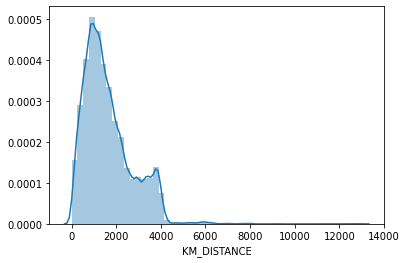

In [31]:
#distribution of the distance users connect from
#This loads the data to a Pandas DataFrame, and uses "seaborn" open source visualization library

sns.distplot(tdf_distance.to_pandas()['KM_DISTANCE'].astype(float), bins=50);

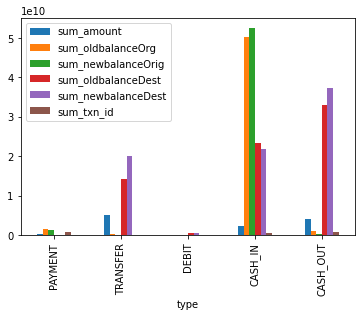

In [32]:
#Do a bunch of work to filter, group, aggregate, retrieve, and format our chart
tdf_ip_data.drop(['step', 'isFraud', 'isFlaggedFraud'], axis = 1).groupby('type').sum().to_pandas().set_index('type').plot(kind = 'bar');

<hr>
<b style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Cleanup</b>
<p style = 'font-size:16px;font-family:Arial'>It is a good practice to remove the context that we created to connect to Vantage</p>

In [33]:
eng.execute('DROP TABLE CUSTOMER;')

In [34]:
eng.execute('DROP TABLE SERVER;')

In [35]:
remove_context()

True

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2022 Teradata. All Rights Reserved</footer>